In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

In [3]:
# Load dataset
DATA_FILE = "hand_keypoints.csv"
df = pd.read_csv(DATA_FILE)

# Extract features (x, y) and labels (A-Z or "space")
X = df.drop(columns=["folder", "filename"]).values
y = df["folder"].values

# Create alphabet mapping
alphabet_mapping = {chr(i): i - ord('A') for i in range(ord('A'), ord('Z') + 1)}
alphabet_mapping["space"] = 26
print("Alphabet Mapping:", alphabet_mapping)

# Convert labels to numerical
y = np.array([alphabet_mapping[label] for label in y])

# Normalize features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the scaler for real-time predictions
joblib.dump(scaler, "scaler.pkl")
joblib.dump(alphabet_mapping, "alphabet_mapping.pkl")

# Convert labels to one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=27)

# Reshape data for CNN (assuming 21 landmarks × 2 coordinates = 42 features)
# Reshape to (21, 2, 1) - 21 landmarks, 2 coordinates, 1 channel
X = X.reshape(-1, 21, 2, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")

Alphabet Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'space': 26}
Training data: (10760, 21, 2, 1), Testing data: (2690, 21, 2, 1)


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation="relu", input_shape=(21, 2, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(27, activation="softmax")
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4605 - loss: 1.8798 - val_accuracy: 0.9937 - val_loss: 0.0574
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.0758 - val_accuracy: 0.9963 - val_loss: 0.0171
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9933 - loss: 0.0290 - val_accuracy: 0.9989 - val_loss: 0.0047
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9942 - loss: 0.0234 - val_accuracy: 0.9978 - val_loss: 0.0099
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9954 - loss: 0.0172 - val_accuracy: 0.9967 - val_loss: 0.0082
Epoch 6/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9927 - loss: 0.0192 - val_accuracy: 0.9944 - val_loss: 0.0154
Epoch 7/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9970 - loss: 0.0094 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 8/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.9999 - loss: 0.0011   
Test Accuracy: 1.00


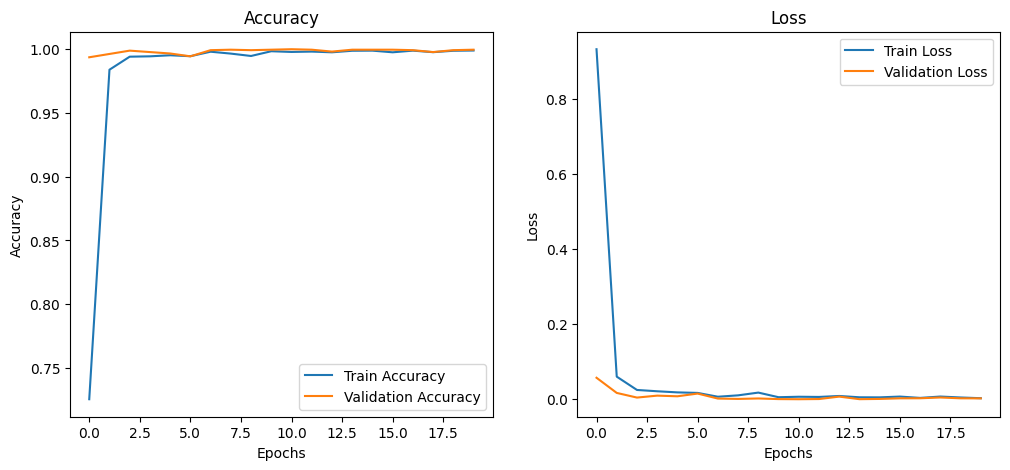

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [23]:
model.save("/Users/user/Desktop/cnn2/hand_sign_cnn_model.h5")
print("Model saved as 'hand_sign_cnn_model.h5'")

Model saved as 'hand_sign_cnn_model.h5'


In [25]:
import joblib

# Save the scaler
joblib.dump(scaler, '/Users/user/Desktop/cnn2/scaler.pkl')
print("Scaler saved as scaler.pkl")

# Save the alphabet mapping
joblib.dump(alphabet_mapping, '/Users/user/Desktop/cnn2/alphabet_mapping.pkl')
print("Alphabet mapping saved as alphabet_mapping.pkl")

Scaler saved as scaler.pkl
Alphabet mapping saved as alphabet_mapping.pkl


In [21]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import joblib

# Load trained model and scaler
model = tf.keras.models.load_model("hand_sign_model.h5")
scaler = joblib.load("scaler.pkl")
alphabet_mapping = joblib.load("alphabet_mapping.pkl")
reverse_mapping = {v: k for k, v in alphabet_mapping.items()}

# Initialize MediaPipe for hand tracking
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)

# Open webcam
cap = cv2.VideoCapture(0)

print("Real-time hand sign recognition started. Press 'q' to exit.")
sentence = []

# Variables for tracking sign consistency
current_sign = None
sign_start_time = None
last_sign_time = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract landmarks
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y])

            # Normalize landmarks using the scaler
            normalized_landmarks = scaler.transform([landmarks])

            # If using CNN, reshape for input
            if len(model.input_shape) == 4:  # CNN (expects 4D)
                normalized_landmarks = normalized_landmarks.reshape(1, 21, 2, 1)

            # Predict sign
            prediction = model.predict(normalized_landmarks)
            predicted_label = np.argmax(prediction)
            predicted_letter = reverse_mapping[predicted_label]

            # Track sign for 3 seconds for sentence formation
            if predicted_letter == current_sign:
                if (cv2.getTickCount() - sign_start_time) / cv2.getTickFrequency() >= 3:
                    sentence.append(predicted_letter)
                    current_sign = None
            else:
                current_sign = predicted_letter
                sign_start_time = cv2.getTickCount()

            # Display prediction
            cv2.putText(frame, f"Prediction: {predicted_letter}", (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display sentence
    sentence_text = " ".join(sentence)
    cv2.putText(frame, f"Sentence: {sentence_text}", (10, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Show video frame
    cv2.imshow("Hand Sign Recognition", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'hand_sign_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)